## Computing transport in a section

In [26]:
import numpy as np
import xarray as xr
#import xorca_brokenline as bl
#import cmocean as co     # for details on this colormap module see https://matplotlib.org/cmocean/
from matplotlib import colors as c
from matplotlib import pyplot as plt
from pathlib import Path
#import seawater
%matplotlib inline

In [27]:
plt.rcParams['figure.figsize'] = [20, 7]
plt.rcParams.update({'font.size': 17})

global_data_path = Path("/Users/pvb/Downloads/GeomarData")
experiment_id = "INALT20.L46-KFS044"
nest_prefix = "1_"  # leave empty if global data will be used
code_area = "_9W_35S10S"
time_average = "5d"

In [28]:
# chunk sizes
chu_x = 21
chu_y = 551
chu_z = 46
chu_t = 1

## Start Dask client

We want to be able to control the resources used for parallel computations.

In [29]:
from dask.distributed import Client
client = Client(n_workers=1, threads_per_worker=8, memory_limit=8e9)
client

/usr/local/anaconda3/lib/python3.7/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


Client Scheduler: tcp://127.0.0.1:53004 Dashboard: http://127.0.0.1:53005/status,Cluster Workers: 1 Cores: 8 Memory: 8.00 GB


## Data files

In [30]:
MESH_MASK_files = list(sorted(
    (global_data_path / "mask" / experiment_id).glob(
        f"{nest_prefix}mesh_mask{code_area}.nc"
    )
))

U_files = list(sorted(
    (global_data_path / "data" / experiment_id).glob(
        f"{nest_prefix}{experiment_id}_{time_average}_200*_*_grid_U{code_area}.nc"
    )
))

V_files = list(sorted(
    (global_data_path / "data" / experiment_id).glob(
        f"{nest_prefix}{experiment_id}_{time_average}_200*_*_grid_V{code_area}.nc"
    )
))

print(f"Found {len(MESH_MASK_files)} mesh/mask files, {len(U_files)} U files, and {len(V_files)} V files.")

Found 1 mesh/mask files, 10 U files, and 10 V files.


In [31]:
MESH_MASK_files

[PosixPath('/Users/pvb/Downloads/GeomarData/mask/INALT20.L46-KFS044/1_mesh_mask_9W_35S10S.nc')]

## Load Data

In [32]:
#Auxiliary data
ds_mesh_mask = xr.open_mfdataset(
    MESH_MASK_files,
    chunks={
        "z": chu_z,
        "y": chu_y,
        "x": chu_x
    },
    combine='by_coords')
#ds_mesh_mask = ds_mesh_mask.squeeze()  # remove degenerate time dim
#ds_mesh_mask = ds_mesh_mask.set_coords(["nav_lat", "nav_lon"])
#neccesary for xorca_brokenline to work
#ds_mesh_mask = ds_mesh_mask.expand_dims('t')
#ds_mesh_mask = ds_mesh_mask.rename({'nav_lev':'nav_lev_0'})
#ds_mesh_mask['nav_lev'] = ds_mesh_mask.nav_lev_0.isel(t=0)
ds_mesh_mask = ds_mesh_mask.rename({'e3t_0':'e3t','e3u_0':'e3u','e3v_0':'e3v'})

ds_mesh_mask

<xarray.Dataset>
Dimensions:       (t: 1, x: 21, y: 551, z: 46)
Dimensions without coordinates: t, x, y, z
Data variables:
    nav_lon       (y, x) float32 dask.array<chunksize=(551, 21), meta=np.ndarray>
    nav_lat       (y, x) float32 dask.array<chunksize=(551, 21), meta=np.ndarray>
    nav_lev       (z) float32 dask.array<chunksize=(46,), meta=np.ndarray>
    time_counter  (t) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    tmask         (t, z, y, x) int8 dask.array<chunksize=(1, 46, 551, 21), meta=np.ndarray>
    umask         (t, z, y, x) int8 dask.array<chunksize=(1, 46, 551, 21), meta=np.ndarray>
    vmask         (t, z, y, x) int8 dask.array<chunksize=(1, 46, 551, 21), meta=np.ndarray>
    fmask         (t, z, y, x) int8 dask.array<chunksize=(1, 46, 551, 21), meta=np.ndarray>
    tmaskutil     (t, y, x) int8 dask.array<chunksize=(1, 551, 21), meta=np.ndarray>
    umaskutil     (t, y, x) int8 dask.array<chunksize=(1, 551, 21), meta=np.ndarray>
    vmaskutil     (t, y, x) int8 dask.array<chunksize=(1, 551, 21), meta=np.ndarray>
    fmaskutil     (t, y, x) int8 dask.array<chunksize=(1, 551, 21), meta=np.ndarray>
    glamt         (t, y, x) float32 dask.array<chunksize=(1, 551, 21), meta=np.ndarray>
    glamu         (t, y, x) float32 dask.array<chunksize=(1, 551, 21), meta=np.ndarray>
    glamv         (t, y, x) float32 dask.array<chunksize=(1, 551, 21), meta=np.ndarray>
    glamf         (t, y, x) float32 dask.array<chunksize=(1, 551, 21), meta=np.ndarray>
    gphit         (t, y, x) float32 dask.array<chunksize=(1, 551, 21), meta=np.ndarray>
    gphiu         (t, y, x) float32 dask.array<chunksize=(1, 551, 21), meta=np.ndarray>
    gphiv         (t, y, x) float32 dask.array<chunksize=(1, 551, 21), meta=np.ndarray>
    gphif         (t, y, x) float32 dask.array<chunksize=(1, 551, 21), meta=np.ndarray>
    e1t           (t, y, x) float64 dask.array<chunksize=(1, 551, 21), meta=np.ndarray>
    e1u           (t, y, x) float64 dask.array<chunksize=(1, 551, 21), meta=np.ndarray>
    e1v           (t, y, x) float64 dask.array<chunksize=(1, 551, 21), meta=np.ndarray>
    e1f           (t, y, x) float64 dask.array<chunksize=(1, 551, 21), meta=np.ndarray>
    e2t           (t, y, x) float64 dask.array<chunksize=(1, 551, 21), meta=np.ndarray>
    e2u           (t, y, x) float64 dask.array<chunksize=(1, 551, 21), meta=np.ndarray>
    e2v           (t, y, x) float64 dask.array<chunksize=(1, 551, 21), meta=np.ndarray>
    e2f           (t, y, x) float64 dask.array<chunksize=(1, 551, 21), meta=np.ndarray>
    ff            (t, y, x) float64 dask.array<chunksize=(1, 551, 21), meta=np.ndarray>
    mbathy        (t, y, x) int16 dask.array<chunksize=(1, 551, 21), meta=np.ndarray>
    misf          (t, y, x) int16 dask.array<chunksize=(1, 551, 21), meta=np.ndarray>
    isfdraft      (t, y, x) float32 dask.array<chunksize=(1, 551, 21), meta=np.ndarray>
    e3t           (t, z, y, x) float64 dask.array<chunksize=(1, 46, 551, 21), meta=np.ndarray>
    e3u           (t, z, y, x) float64 dask.array<chunksize=(1, 46, 551, 21), meta=np.ndarray>
    e3v           (t, z, y, x) float64 dask.array<chunksize=(1, 46, 551, 21), meta=np.ndarray>
    e3w_0         (t, z, y, x) float64 dask.array<chunksize=(1, 46, 551, 21), meta=np.ndarray>
    gdept_0       (t, z, y, x) float32 dask.array<chunksize=(1, 46, 551, 21), meta=np.ndarray>
    gdepu         (t, z, y, x) float32 dask.array<chunksize=(1, 46, 551, 21), meta=np.ndarray>
    gdepv         (t, z, y, x) float32 dask.array<chunksize=(1, 46, 551, 21), meta=np.ndarray>
    gdepw_0       (t, z, y, x) float32 dask.array<chunksize=(1, 46, 551, 21), meta=np.ndarray>
    gdept_1d      (t, z) float64 dask.array<chunksize=(1, 46), meta=np.ndarray>
    gdepw_1d      (t, z) float64 dask.array<chunksize=(1, 46), meta=np.ndarray>
    e3t_1d        (t, z) float64 dask.array<chunksize=(1, 46), meta=np.ndarray>
    e3w_1d        (t, z) float64 dask.array<chunksize=(1, 46), meta=np.ndarray>
Attributes:
    hist

In [33]:
ds_U = xr.open_mfdataset(
    U_files,
    chunks={
        "time_counter": chu_t,
        "depthu": chu_z,
        "y": chu_y,
        "x": chu_x
    },
    combine='by_coords')

In [34]:
ds_V = xr.open_mfdataset(
    V_files,
    chunks={
        "time_counter": chu_t,
        "depthv": chu_z,
        "y": chu_y,
        "x": chu_x
    },
    combine='by_coords')

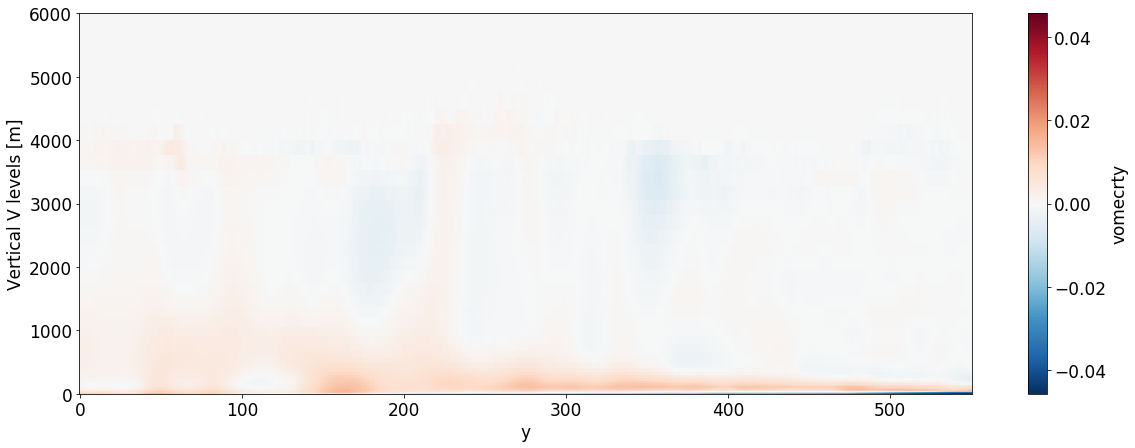

In [35]:
ds_V.mean(dim='time_counter').mean(dim='x').vomecrty.plot()

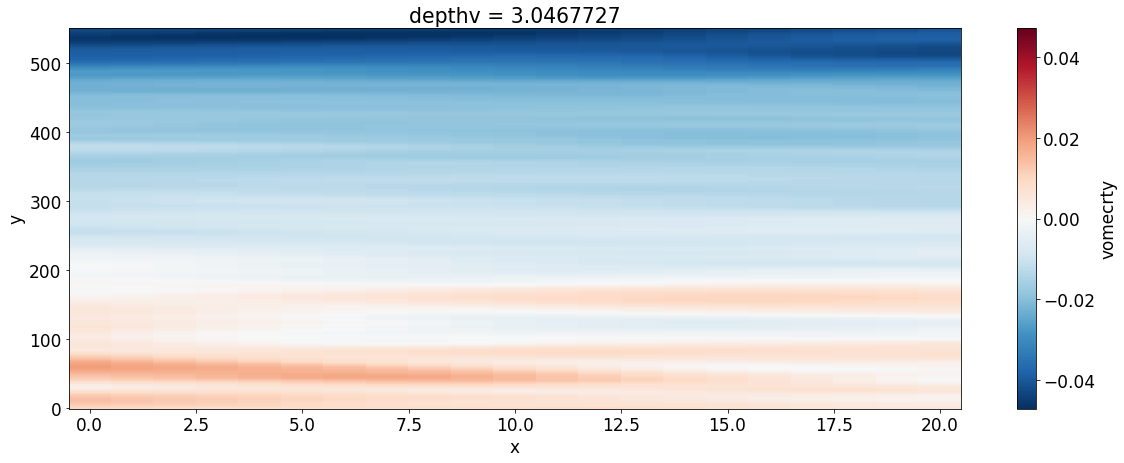

In [36]:
ds_V.mean(dim='time_counter').isel(depthv=0).vomecrty.plot()

## Define section

In [20]:
lon_sa_min=-50
lon_sa_max= 15
lat_sa_min=-32.5
lat_sa_max=-30

lonv = ds_U.nav_lon.isel(y=0).values
ilonv_min = (np.abs(lonv-lon_sa_min)).argmin()
ilonv_max = (np.abs(lonv-lon_sa_max)).argmin()

latv = ds_U.nav_lat.isel(x=0).values
ilatv_min = (np.abs(latv-lat_sa_min)).argmin()
ilatv_max = (np.abs(latv-lat_sa_max)).argmin()

print('ilon:',ilonv_min,ilonv_max)
print('ilat:',ilatv_min,ilatv_max)

ilon: 0 20
ilat: 62 121


In [21]:
ji_pairs = [
    (ilatv_min, ilonv_min),
    (ilatv_max,ilonv_max)
]

In [22]:
fmask = ds_mesh_mask['fmask'].isel(z=0,t=0)

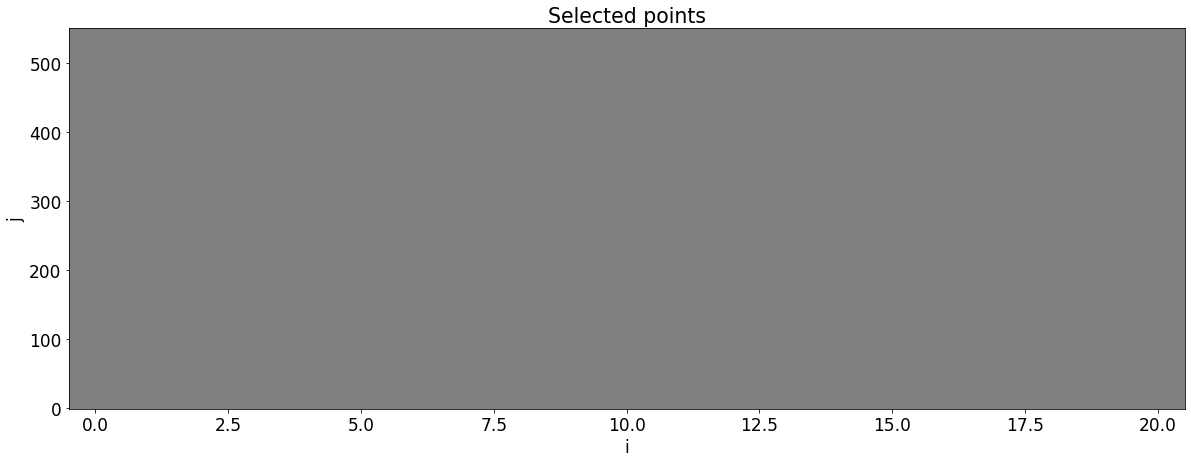

In [23]:
fmask.plot(cmap=c.ListedColormap(['gray','white']),add_colorbar=0)
#plt.plot(ii,jj,'x')

plt.ylabel("j")
plt.xlabel("i")
plt.title('Selected points');

## Extract Section
bl.shift_grids() interpolates all variables onto the u- and v-points, drops unnecessary coordinate labels and variables and renames depth dimension. <br>
select_section() selects the section defined by ji from gridU_processed and gridV_processed and returns a section.


In [24]:
bl.select_section?

Object `bl.select_section` not found.


In [25]:
ji = bl.section_indices(ji_pairs=ji_pairs)
gridU_processed, gridV_processed = bl.shift_grids(gridU=ds_U, gridV=ds_V)
section = bl.select_section(
    ji,gridU_processed,gridV_processed,ds_mesh_mask,ds_mesh_mask,ds_mesh_mask
    ).compute()

NameError: name 'bl' is not defined

distributed.nanny - WARNING - Restarting worker


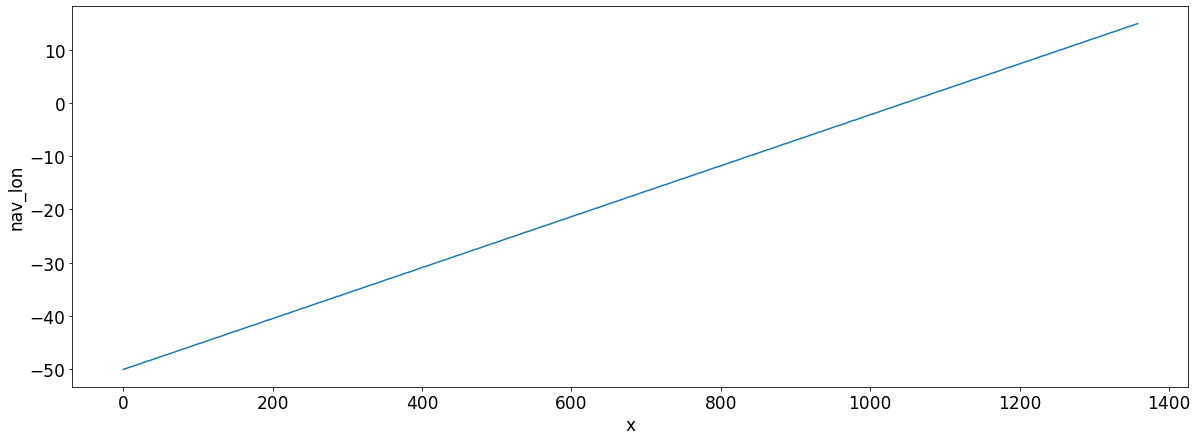

In [47]:
ji = bl.section_indices(ji_pairs=ji_pairs)
#lij=list(ji)
#len(lij)

lji = [tuple(ji2) for ji2 in ji]
sali=np.array(lji)

#nav_lat       (t, y, x) 
lon1=ds_mesh_mask.nav_lon.isel(t=0,y=sali[:,0],x=sali[:,1])
lon2=lon1.isel(y=0)[:-1]
lon2.plot()

In [44]:
section

<xarray.Dataset>
Dimensions:       (c: 1359, time_counter: 12, z: 46)
Coordinates:
  * c             (c) float64 4.69e+03 9.38e+03 ... 6.456e+06 6.461e+06
  * z             (z) float64 3.047 9.454 16.36 ... 5.625e+03 5.875e+03
  * time_counter  (time_counter) datetime64[ns] 2010-01-16T12:00:00 ... 2010-12-16T12:00:00
Data variables:
    u_normal      (time_counter, z, c) float64 0.1895 0.1634 0.1487 ... 0.0 0.0
    dx            (c) float64 4.69e+03 4.69e+03 4.69e+03 ... 4.817e+03 4.817e+03
    dz            (z, c) float64 6.191 6.191 6.191 6.191 ... 250.4 250.4 250.4
    mask          (z, c) float32 1.0 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0 0.0

In [114]:
section

<xarray.Dataset>
Dimensions:       (c: 1359, time_counter: 12, z: 46)
Coordinates:
  * c             (c) float64 4.69e+03 9.38e+03 ... 6.456e+06 6.461e+06
  * z             (z) float64 3.047 9.454 16.36 ... 5.625e+03 5.875e+03
  * time_counter  (time_counter) datetime64[ns] 2010-01-16T12:00:00 ... 2010-12-16T12:00:00
Data variables:
    u_normal      (time_counter, z, c) float64 0.1895 0.1634 0.1487 ... 0.0 0.0
    dx            (c) float64 4.69e+03 4.69e+03 4.69e+03 ... 4.817e+03 4.817e+03
    dz            (z, c) float64 6.191 6.191 6.191 6.191 ... 250.4 250.4 250.4
    mask          (z, c) float32 1.0 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0 0.0

Section includes the velocity normal to the section (either U or V, depending on the orientation of each segment), the length and depth of each segment and a land-sea mask variable. 

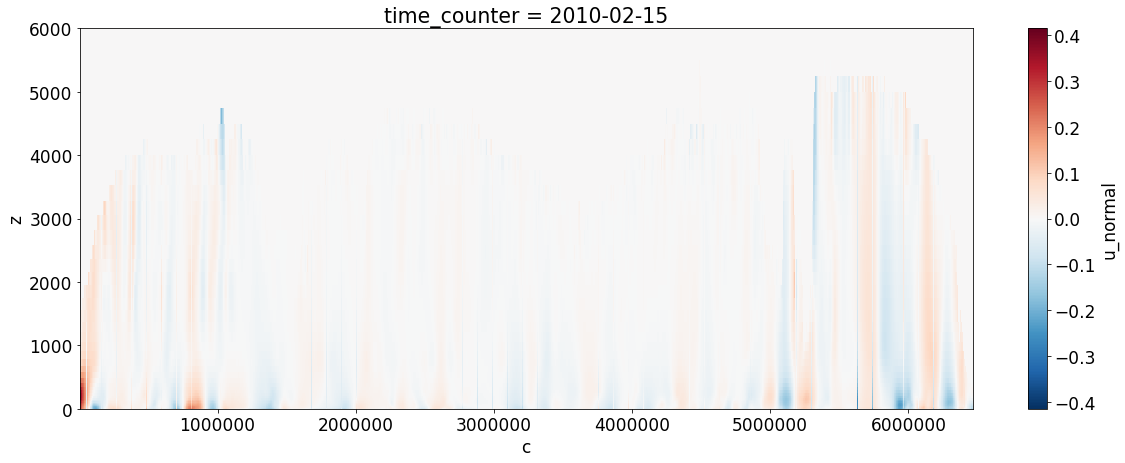

In [53]:
section['u_normal'].isel(time_counter=1).plot()

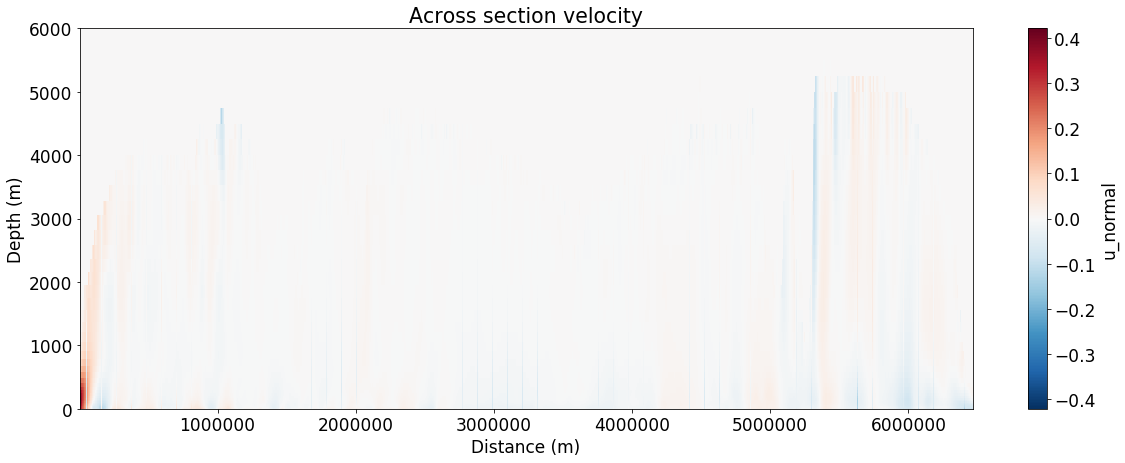

In [48]:
section['u_normal'].mean('time_counter').plot()
#section['mask'].where(section['mask']==0).plot(cmap=c.ListedColormap(['gray']),add_colorbar=0)
plt.ylabel("Depth (m)")
plt.xlabel("Distance (m)")
plt.title("Across section velocity");

## Volume Transport

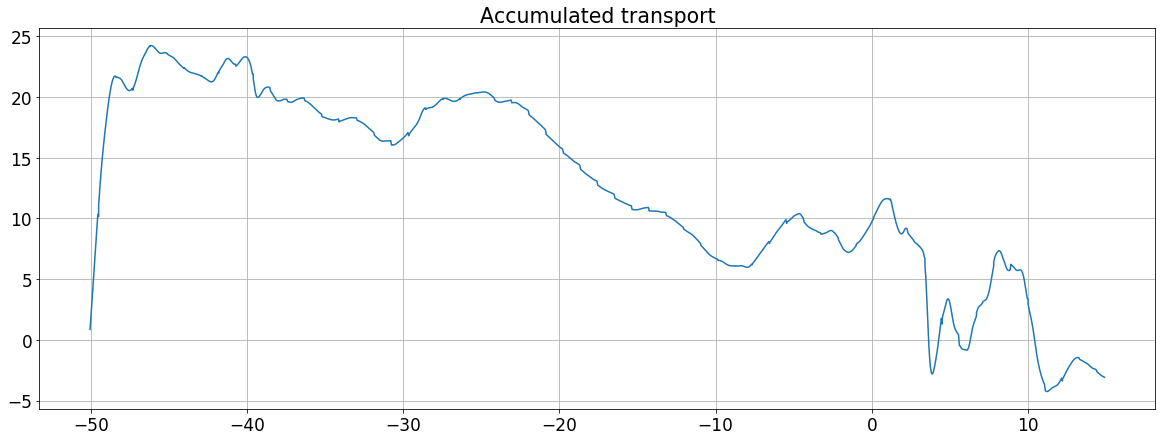

In [60]:
transport = bl.calculate_transport(section)
transport.values()

Int1 = section.u_normal*section.dx*section.dz/1e6
Inty2 = Int1.sum('z').cumsum('c').mean(dim = "time_counter")

fig, ax = plt.subplots()
ax.plot(lon2,Inty2)
plt.grid()
plt.title('Accumulated transport');

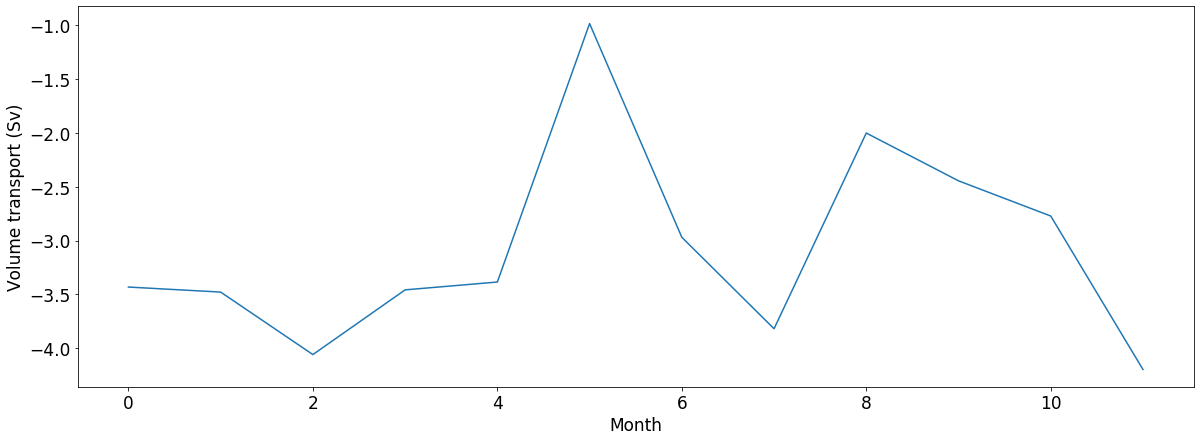

In [50]:
plt.plot(transport['trsp'])
plt.ylabel("Volume transport (Sv)");
plt.xlabel("Month");